In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [36]:

# dtype and reproducibility
DTYPE = torch.float32

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

# sampling and KL divergence
def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

def kl_divergence(mu, logvar):
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1).mean()

# improved convolutional encoder with deeper features
class ConvEncoder(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1), nn.BatchNorm2d(32), nn.LeakyReLU(),
            nn.Conv2d(32, 32, 3, 2, 1), nn.BatchNorm2d(32), nn.LeakyReLU()
        )  # 28->14
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, 1, 1), nn.BatchNorm2d(64), nn.LeakyReLU(),
            nn.Conv2d(64, 64, 3, 2, 1), nn.BatchNorm2d(64), nn.LeakyReLU()
        )  # 14->7
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1, 1), nn.BatchNorm2d(128), nn.LeakyReLU(),
            nn.Conv2d(128, 128, 3, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(),
            nn.Flatten()
        )  # 7->4
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)

    def forward(self, x):
        h = self.conv1(x)
        h = self.conv2(h)
        h = self.conv3(h)
        return self.fc_mu(h), self.fc_logvar(h)


In [37]:

# improved convolutional decoder with extra upsampling
class ConvDecoder(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 128 * 4 * 4), nn.LeakyReLU()
        )
        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.LeakyReLU()
        )  # 4->8
        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.LeakyReLU()
        )  # 8->16
        self.deconv3 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 4, 2, 1), nn.BatchNorm2d(16), nn.LeakyReLU()
        )  # 16->32
        self.final = nn.Sequential(
            nn.Conv2d(16, 1, 3, 1, 1), nn.Sigmoid()
        )  # will crop to 28

    def forward(self, z):
        x = self.fc(z).view(-1, 128, 4, 4)
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)
        x = x[:, :, 2:30, 2:30]
        return self.final(x)

# UWVAE_I2M2 model with improved encoder/decoder
class UWVAE_I2M2(nn.Module):
    def __init__(self, latent_dim=64, num_classes=10):
        super().__init__()
        self.encoder1 = ConvEncoder(latent_dim)
        self.encoder2 = ConvEncoder(latent_dim)
        self.decoder = ConvDecoder(latent_dim)
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, 128), nn.BatchNorm1d(128), nn.LeakyReLU(), nn.Dropout(0.3),
            nn.Linear(128, 64), nn.BatchNorm1d(64), nn.LeakyReLU(), nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x1, x2):
        mu1, lv1 = self.encoder1(x1)
        mu2, lv2 = self.encoder2(x2)
        z1 = reparameterize(mu1, lv1)
        z2 = reparameterize(mu2, lv2)
        z = (z1 + z2) / 2
        recon = self.decoder(z)
        logits = self.classifier(z)
        kl = kl_divergence(mu1, lv1) + kl_divergence(mu2, lv2)
        return recon, logits, kl, z1, z2

    def forward_inference(self, x1, x2, missing=None):
        if missing == 'mod1':
            mu2, lv2 = self.encoder2(x2); z = reparameterize(mu2, lv2)
        elif missing == 'mod2':
            mu1, lv1 = self.encoder1(x1); z = reparameterize(mu1, lv1)
        else:
            mu1, lv1 = self.encoder1(x1); mu2, lv2 = self.encoder2(x2)
            z = (reparameterize(mu1, lv1) + reparameterize(mu2, lv2)) / 2
        recon = self.decoder(z)
        logits = self.classifier(z)
        return recon, logits

# beta schedule
def get_beta(epoch, cycle=10, max_beta=0.01):
    pos = (epoch - 1) % cycle + 1
    return max_beta * min(1.0, pos / (cycle / 2))

# training loop with One-Cycle LR and augmentation
def train_model(seed=42, latent_dim=64, batch_size=128, epochs=50, max_beta=0.01):
    set_seed(seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transform = transforms.Compose([
        transforms.RandomRotation(10),
        transforms.RandomCrop(28, padding=4),
        transforms.ToTensor(),
    ])
    dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    total = len(dataset)
    train_size = int(0.9 * total)
    train_ds, val_ds = random_split(dataset, [train_size, total - train_size])
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size * 2)

    model = UWVAE_I2M2(latent_dim).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=1e-3,
        epochs=epochs,
        steps_per_epoch=len(train_loader),
        pct_start=0.1,
        anneal_strategy='cos'
    )
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = correct = total_samples = 0
        beta = get_beta(epoch, cycle=10, max_beta=max_beta)

        for x, y in train_loader:
            x = x.to(device, dtype=DTYPE)
            x2 = torch.rot90(x, 1, [2, 3])
            y = y.to(device)
            optimizer.zero_grad()
            recon, logits, kl, z1, z2 = model(x, x2)
            # losses
            class_loss = criterion(logits, y)
            recon_loss = F.mse_loss(recon, x)
            kl_loss = beta * torch.clamp(kl, max=10.0)
            loss = class_loss + recon_loss + kl_loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
            scheduler.step()
            train_loss += loss.item() * x.size(0)
            correct += (logits.argmax(1) == y).sum().item()
            total_samples += y.size(0)

        train_loss /= total_samples
        train_acc = correct / total_samples

        model.eval()
        val_loss = correct = total_samples = 0
        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(device, dtype=DTYPE)
                x2 = torch.rot90(x, 1, [2, 3])
                y = y.to(device)
                recon, logits, kl, _, _ = model(x, x2)
                loss = criterion(logits, y) + F.mse_loss(recon, x) + beta * torch.clamp(kl, max=10.0)
                val_loss += loss.item() * x.size(0)
                correct += (logits.argmax(1) == y).sum().item()
                total_samples += y.size(0)

        val_loss /= total_samples
        val_acc = correct / total_samples

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch:2d}: Train Loss {train_loss:.4f} Acc {train_acc:.4f}"
              f" | Val Loss {val_loss:.4f} Acc {val_acc:.4f}")

    return model, device, history


In [38]:

# visualization: reconstruction loss by class
def visualize_reconstruction_loss_by_class(model, dataloader, device):
    model.eval()
    losses = {i: [] for i in range(10)}
    crit = nn.MSELoss(reduction='none')
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device, dtype=DTYPE)
            x2 = torch.rot90(x, 1, [2, 3])
            recon, _, _, _, _ = model(x, x2)
            batch_loss = crit(recon, x).view(x.size(0), -1).mean(dim=1)
            for l, label in zip(batch_loss.cpu(), y): losses[int(label)].append(l.item())
    avg = {k: np.mean(v) for k, v in losses.items()}
    plt.figure(figsize=(8,4))
    plt.bar(avg.keys(), avg.values())
    plt.xlabel('Digit Class'); plt.ylabel('Avg Recon Loss'); plt.title('Recon Loss by Class'); plt.show()

# visualization: inference samples
def visualize_inference_samples(model, dataloader, device, num_samples=5):
    model.eval()
    x, y = next(iter(dataloader))
    x, y = x[:num_samples].to(device, dtype=DTYPE), y[:num_samples]
    x2 = torch.rot90(x, 1, [2, 3])
    with torch.no_grad(): recon, logits, _, _, _ = model(x, x2)
    preds = logits.argmax(1).cpu().numpy()
    fig, axes = plt.subplots(num_samples, 2, figsize=(4, num_samples*2))
    for i in range(num_samples):
        axes[i,0].imshow(x.cpu()[i].squeeze(), cmap='gray'); axes[i,0].set_title(f'T:{y[i].item()}'); axes[i,0].axis('off')
        axes[i,1].imshow(recon.cpu()[i].squeeze(), cmap='gray'); axes[i,1].set_title(f'P:{preds[i]}'); axes[i,1].axis('off')
    plt.tight_layout(); plt.show()

# confusion matrix generator
def generate_confusion_matrix(model, dataloader, device, missing=None):
    model.eval()
    all_y, all_preds = [], []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device, dtype=DTYPE)
            x2 = torch.rot90(x, 1, [2, 3])
            recon, logits = model.forward_inference(x, x2, missing)
            all_preds.extend(logits.argmax(1).cpu().numpy())
            all_y.extend(y.numpy())
    cm = confusion_matrix(all_y, all_preds)
    
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted'); plt.ylabel('True'); plt.title(f'Confusion Matrix (missing={missing})'); plt.show()

# enhanced missing-modality visualization
def visualize_missing_modality(model, dataloader, device, num_samples=5):
    model.eval()
    x_batch, y_batch = next(iter(dataloader))
    x = x_batch[:num_samples].to(device, dtype=DTYPE)
    x2 = torch.rot90(x, 1, [2,3])
    y = y_batch[:num_samples].cpu().numpy()

    variants = [('full', None), ('missing_mod1', 'mod1'), ('missing_mod2', 'mod2')]
    reconstructions, predictions = {}, {}
    with torch.no_grad():
        for name, flag in variants:
            recon, logits = model.forward_inference(x, x2, missing=flag)
            reconstructions[name] = recon.cpu()
            predictions[name] = logits.argmax(1).cpu().numpy()

    fig, axes = plt.subplots(num_samples, len(variants)+1, figsize=(3*(len(variants)+1), num_samples*3))
    for i in range(num_samples):
        axes[i,0].imshow(x_batch[i].squeeze(), cmap='gray'); axes[i,0].set_title(f'True: {y[i]}'); axes[i,0].axis('off')
        for j, (name, _) in enumerate(variants, start=1):
            axes[i,j].imshow(reconstructions[name][i].squeeze(), cmap='gray')
            axes[i,j].set_title(f'{name}\nPred: {predictions[name][i]}')
            axes[i,j].axis('off')
    plt.tight_layout(); plt.show()


Epoch  1: Train Loss 2.0215 Acc 0.4148 | Val Loss 1.2097 Acc 0.9020
Epoch  2: Train Loss 0.9189 Acc 0.9404 | Val Loss 0.6888 Acc 0.9677
Epoch  3: Train Loss 0.7286 Acc 0.9714 | Val Loss 0.6893 Acc 0.9657
Epoch  4: Train Loss 0.7090 Acc 0.9776 | Val Loss 0.6684 Acc 0.9763
Epoch  5: Train Loss 0.7074 Acc 0.9811 | Val Loss 0.6681 Acc 0.9840
Epoch  6: Train Loss 0.6936 Acc 0.9850 | Val Loss 0.6536 Acc 0.9870
Epoch  7: Train Loss 0.6832 Acc 0.9868 | Val Loss 0.6499 Acc 0.9887
Epoch  8: Train Loss 0.6777 Acc 0.9886 | Val Loss 0.6438 Acc 0.9902
Epoch  9: Train Loss 0.6741 Acc 0.9890 | Val Loss 0.6445 Acc 0.9877
Epoch 10: Train Loss 0.6730 Acc 0.9888 | Val Loss 0.6537 Acc 0.9827
Epoch 11: Train Loss 0.5891 Acc 0.9900 | Val Loss 0.5614 Acc 0.9903
Epoch 12: Train Loss 0.6055 Acc 0.9910 | Val Loss 0.5768 Acc 0.9910
Epoch 13: Train Loss 0.6237 Acc 0.9912 | Val Loss 0.5928 Acc 0.9932
Epoch 14: Train Loss 0.6432 Acc 0.9913 | Val Loss 0.6177 Acc 0.9912
Epoch 15: Train Loss 0.6619 Acc 0.9912 | Val Los

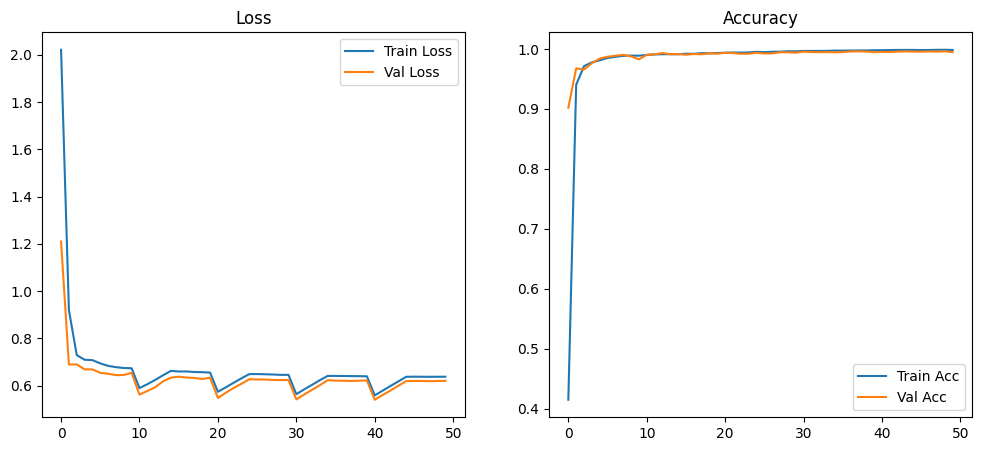

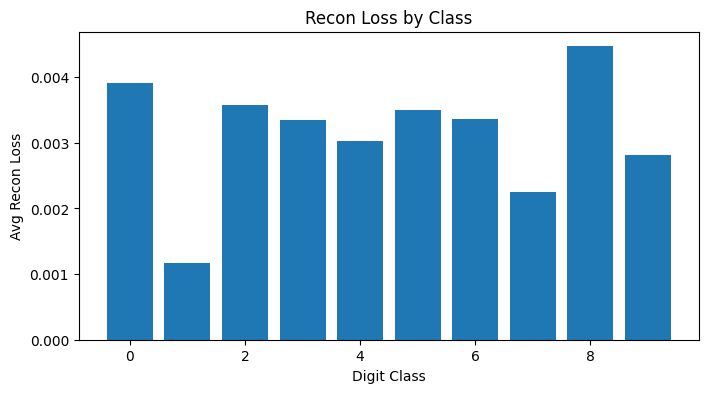

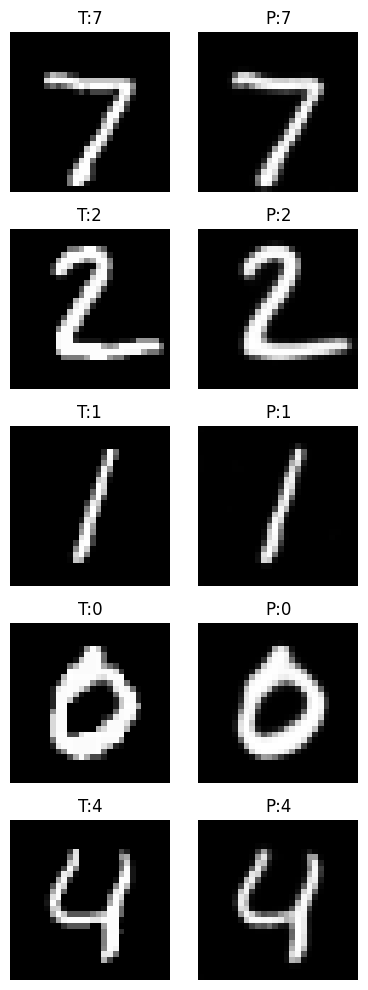

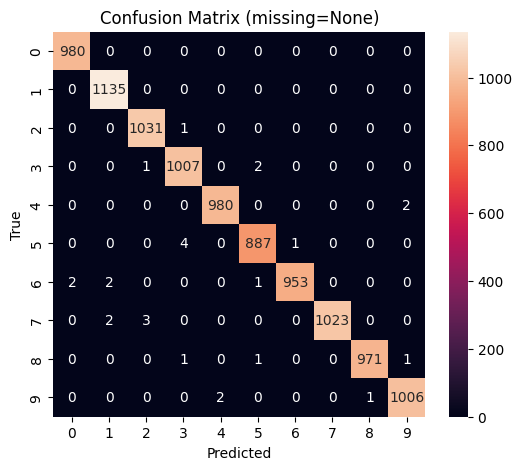

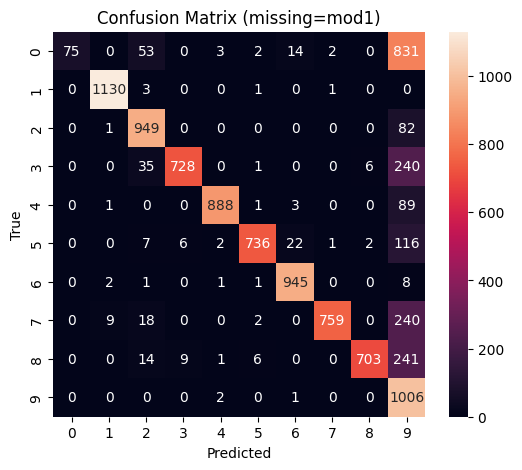

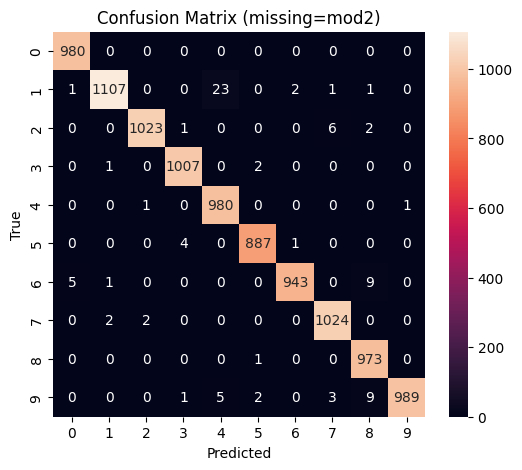

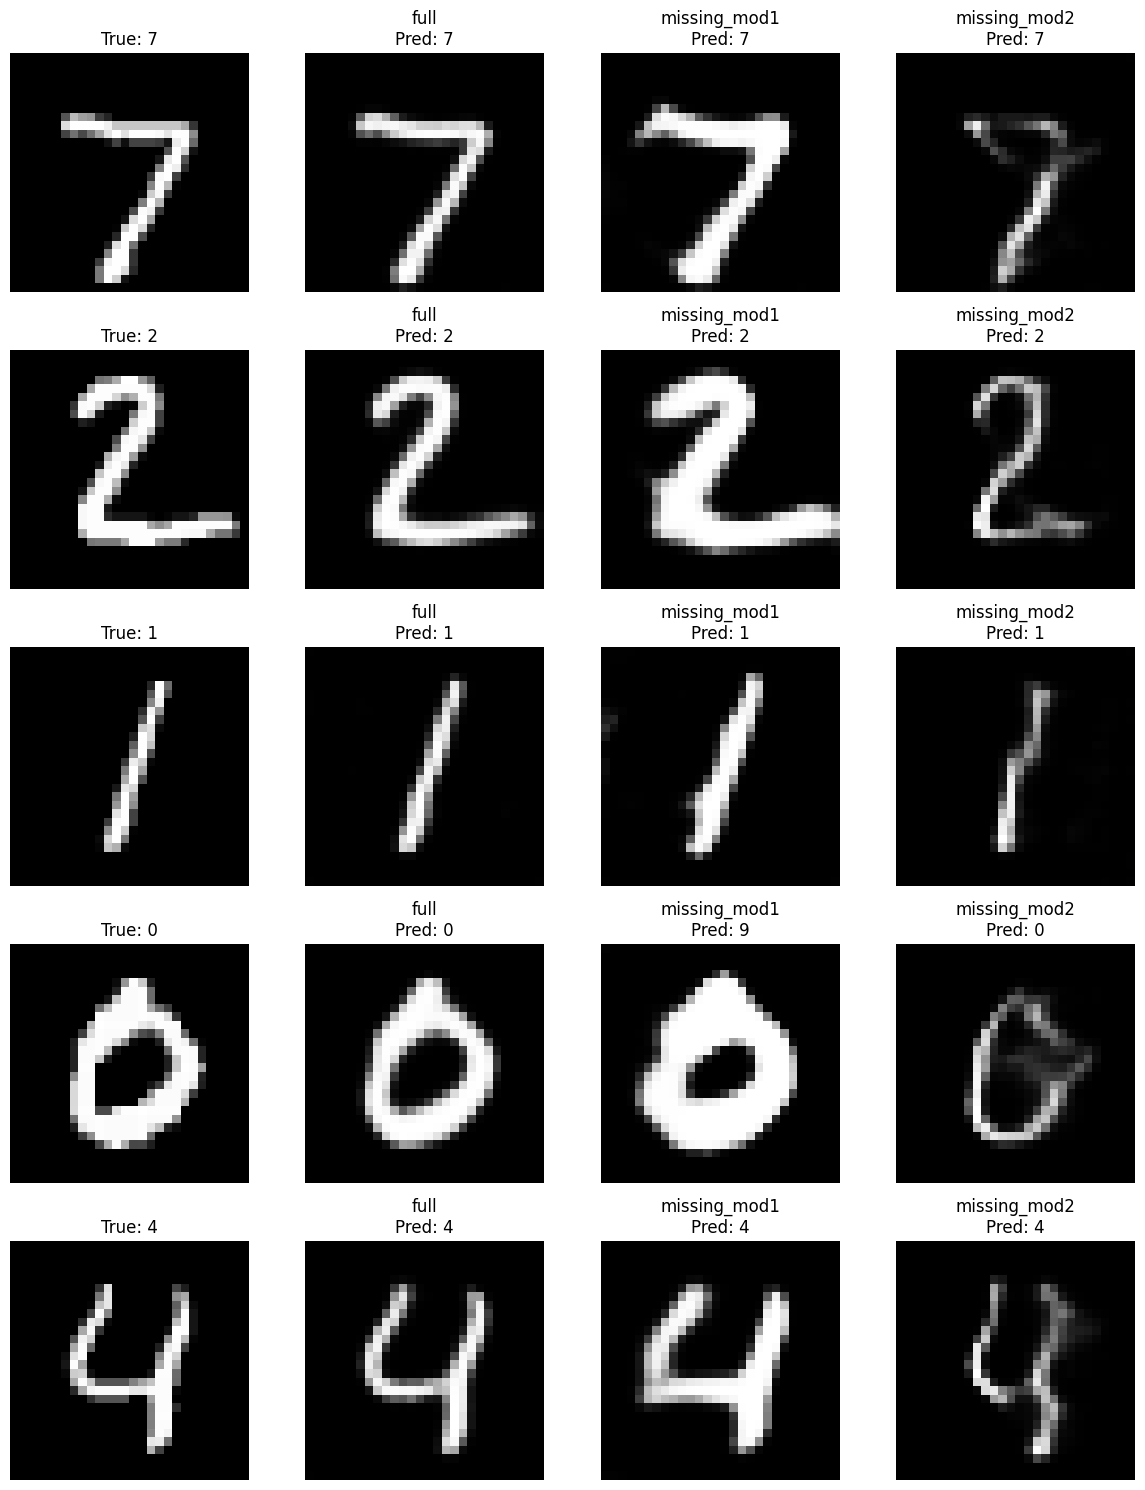

In [39]:

# main execution
def main():
    model, device, history = train_model()
    # plot training history
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.legend(); plt.title('Loss')
    plt.subplot(1,2,2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.legend(); plt.title('Accuracy')
    plt.show()

    # test set visualizations
    test_ds = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
    test_loader = DataLoader(test_ds, batch_size=256)
    visualize_reconstruction_loss_by_class(model, test_loader, device)
    visualize_inference_samples(model, test_loader, device)
    generate_confusion_matrix(model, test_loader, device)
    generate_confusion_matrix(model, test_loader, device, missing='mod1')
    generate_confusion_matrix(model, test_loader, device, missing='mod2')
    visualize_missing_modality(model, test_loader, device)

if __name__ == '__main__':
    main()
